# Auto-wah project

In [2]:
# Install libraries
! pip install audiolazy 
! pip install wave
! pip install scipy

In [325]:
# Imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
import string
import math

# Audio imports
import scipy.signal as sgn
from scipy.io import wavfile
import audiolazy as al
import wave
import sys
from audiolazy import sHz, white_noise, line, resonator, AudioIO, Stream

# Helpers
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [326]:
# Helpers
from helpers import *

# Parameters

Parameters : cuttof freq = milieu entre 500 et 4000
    , res = le 1000 a coté du bw

In [413]:
ma_width = 4000
window = 4000
order = 2

## Import wav file into NumPy array

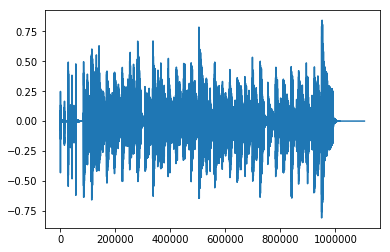

In [496]:
fs, data = wavfile.read('guitarfull.wav') # get data as integers
MAX_VAL = abs(np.iinfo(data.dtype).min) # get max integer
data = data / MAX_VAL # now data is a normalized array of float between -1 and 1
data_length = data.size

plt.plot(data)
IPython.display.Audio(data, rate=fs)

## Compute the envelope of the signal (and set it to interesting freqs)

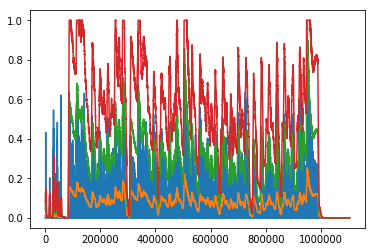

In [514]:
#m_hat = abs(sgn.hilbert(data)) # Compute the hilbert transform

#envelope = smooth(m_hat, ma_width) # Apply a moving average to smooth out the envelope
#envelope /= envelope.max() # Normalize between 0 and 1
#envelope **= 0.6 # Re-elevate the envelope
#envelope = envelope[ma_width//2:]
envelope = np.concatenate((np.zeros(ma_width//2), data, np.zeros(ma_width//2)))
envelope = moving_average(abs(envelope), ma_width)

envelope_log = np.exp(envelope)
envelope_log -= np.min(envelope_log)
envelope_log /= np.max(envelope_log)
envelopeF = envelope_log-np.percentile(envelope_log, 10)
envelopeF /= np.percentile(envelope_log, 95)
envelopeF = np.clip(envelopeF, 0, 1)
envelopeF /= np.max(envelopeF)
plt.plot(abs(data))
plt.plot(envelope)
plt.plot(envelope_log)
plt.plot(envelopeF)
plt.show()

## IIR Filter Method

In [515]:
def autowah(data, envelope, maximum, minimum, peak= True, Q = 1, p=0.8, delay=0, fs = 44100):
    Q = max(Q, 0.5)
    if peak and (p>1 or p < 0):
        raise ValueError("p must be between 0 and 1")
    y = np.zeros(len(data)+ order+1)
    z = np.zeros(len(data)+ order+1)# Create the y (order + 1 zeros at the begining to compute the 1st values...)
    if delay > 0 :
        d = np.concatenate((np.zeros(order+1+int(delay*fs)), data)) # add padded zeros at the beginning
    else:
        d = np.concatenate((np.zeros(order+1), data, np.zeros(int(-delay*fs)))) # add padded zeros at the beginning
    envelope = np.concatenate((np.zeros(order+1), envelope))

    vals_b = np.zeros(order+1)
    vals_a = np.zeros(order+1)

    for i in range(order+1, len(y)): # begin at order+1 since we must use previous values (0)

        if(i%100 == order+1): # sinon trop lent
            cutoff = envelope[i]*(maximum-minimum)/fs*2 + minimum/fs*2
            b, a = sgn.iirfilter(
                      N=order,
                      Wn=(cutoff),     
                      rp=30,
                      rs = 60,
                      btype='lowpass',
                      analog = False,
                      ftype='butter', 
                      output='ba')

        for j in range(0, order+1): # Compute X of the tranfer function
            vals_b[j] = b[j] * d[i-j]

        for j in range(1, order+1): # Compute Y of the tranfer function
            vals_a[j] = a[j] * y[i-j]

        y[i] = (1/a[0]) * ( np.sum(vals_b) - np.sum(vals_a) ) # Transfer function
        
    if peak :
        for i in range(order+1, len(z)): # begin at order+1 since we must use previous values (0)

            if(i%100 == order+1): # sinon trop lent
                cutoff = envelope[i]*(maximum-minimum)/fs*2 + minimum/fs*2
                b2, a2 = sgn.iirpeak(cutoff, Q)

            for j in range(0, order+1): # Compute X of the tranfer function
                vals_b[j] = b2[j] * y[i-j]

            for j in range(1, order+1): # Compute Y of the tranfer function
                vals_a[j] = a2[j] * z[i-j]

            z[i] = (1/a[0]) * ( np.sum(vals_b) - np.sum(vals_a) ) # Transfer function

    return p*z+(1-p)*y

    # y = np.clip(y, -1, 1)


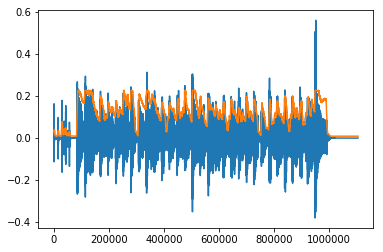

In [517]:
y = autowah(data, envelopeF, maximum = 2000, minimum = 400, peak = True, Q = 0.8, p = 0.8, delay = 0)
plt.plot(y)
plt.plot(envelopeF*(maxi-mini)/fs*2 + mini/fs*2)
plt.show
IPython.display.Audio(y, rate=fs)

## STFT method

In [333]:
# STFT of signal

# nperseg = taille d'un chunk
f, t, Zxx = sgn.stft(x=data, fs=fs, nperseg=1024) 
# f = list the freqs des oscilalteurs
# t = list des temps de debut des fenetres.

Zxx = np.swapaxes(Zxx, 1, 0) 
# Zxx = list des chunks, pour chaque chunk, liste des valeurs des fréquences de la DFT.

num_chunks = t.size # ne pas oublier qu'ils s'overlapent a moitié

# Chunk envelopes list: 1 valeur d'enveloppe par chunk
env_repr = np.asarray([envelope[int(t[i]*fs)] for i in range(num_chunks)])

IndexError: index 462848 is out of bounds for axis 0 with size 462447

In [ ]:
# Le plot des enveloppes representatives est le meme que l'enveloppe normale mais en moins précis
plt.plot(env_repr)

In [12]:
bob = np.zeros((num_chunks, f.size))

# MULTIPLIER LA STFT AVEC UNE LISTE QUI NEST PAS 0 SEULEMENT A L'INCICE CORRESPONDANT A L'ENVELOPPE

for i in range(0, t.size):
    bob[i] = Zxx[i] * 

SyntaxError: invalid syntax (<ipython-input-12-e34022f958df>, line 6)

In [ ]:
plt.plot(bob[2])